# Fig 4: Classifying chronic pain phenotypes using biological and psychosocial modalities

### This notebook contains the analyses code for figure 4:
- Calculate and plot the overlapping sample sizes for the 3 nociplastic conditions (fibromyalgia, chronic fatigue syndrome, and chronic widespread pain)
- Calculate and plot the deviance explained for models trained to predict fibromyalgia based on brain, psychosocial, and their union
- Calculate and plot the deviance explained for models trained to predict chronic pain based on blood/brain, psychosocial, and their union

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
from sklearn.metrics import balanced_accuracy_score,roc_auc_score,matthews_corrcoef,precision_score, recall_score
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import pearsonr
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from confounds import Residualize
from math import pi
import nibabel as nib
import warnings

line_width = 0.5
fs = 6.5

sns.set_context(rc={"font.size":fs})   
plt.rcParams["font.family"] = "Helvetica"
plt.rcParams['figure.dpi'] = 300
plt.rc('mathtext',**{'default':'regular'})
plt.rcParams['font.size'] = fs
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['xtick.major.pad'] = '1.5'
plt.rcParams['ytick.major.pad'] = '1.5'
plt.rcParams['axes.linewidth'] = line_width
plt.rcParams['xtick.major.width'] = line_width
plt.rcParams['ytick.major.width'] = line_width
warnings.filterwarnings("ignore")


color_mapping = {
 'Blood': '#fc8d62',
 'Bone': '#7B66D2',
 'PRS': '#e78ac3',
 'DWI': '#66c2a5',
 'fMRI': '#a6d854',
 'T1': '#ffd92f',
 'Stacked': '#66c2a5',
 'Psycho': '#8da0cb',
 'Psychosocial': '#8da0cb',
 'Psychosocial_T0': '#8da0cb',
 'Psychosocial_T2': '#8da0cb'}

home_dir = '/Users/Patty/Desktop/EVP_lab/'

In [2]:
# Load chronic pain machine learning model results
pain_T0 = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Pain/T0_pain_clf-LR_lin.pickle')
pain_T2 = pd.read_pickle('/Users/Patty/Desktop/Biomarker_Paper/Pickled_Models/Pain/T2_pain_clf-LR_lin.pickle')

In [3]:
# Combine T0 and T2 results into same dictionaries
cp_T0 = {key: value for key, value in pain_T0.items() if 'ChronicPain' in key}
cp_T2 = {key: value for key, value in pain_T2.items() if 'ChronicPain' in key}
cp_T2 = {k: v for k, v in cp_T2.items() if 'Psychosocial' not in k}
cp = cp_T0.copy()
cp.update(cp_T2)

ap_T0 = {key: value for key, value in pain_T0.items() if 'AcutePain' in key}
ap_T2 = {key: value for key, value in pain_T2.items() if 'AcutePain' in key}
ap = ap_T0.copy()
ap.update(ap_T2)

## Plot model performance in classifying ceneral CP based on biological and psychosocial modalities

In [4]:
ap_plot = pd.concat([ap[i]['results_df'][['AUC_test']] for i in ap.keys() if all(x not in i for x in ['DWI', 'T1', 'fMRI'])])
ap_plot.index = [i.split('_LR_lin_')[0] for i in ap_plot.index]
ap_plot = ap_plot.T.melt()[::-1].reset_index(drop=True)
ap_plot['Pain'] = 'Acute (< 3 mos.)'
ap_plot.columns = ['modality','AUC','Pain']

cp_plot = pd.concat([cp[i]['results_df'][['AUC_test']] for i in cp.keys() if all(x not in i for x in ['DWI', 'T1', 'fMRI'])])
cp_plot.index = [i.split('_LR_lin_')[0] for i in cp_plot.index]
cp_plot = cp_plot.T.melt()[::-1].reset_index(drop=True)
cp_plot['Pain'] = 'Chronic (> 3 mos.)'
cp_plot.columns = ['modality','AUC','Pain']

general_plot = pd.concat([cp_plot,ap_plot])
general_plot['modality'] = [i.split('_')[1] for i in general_plot['modality']]

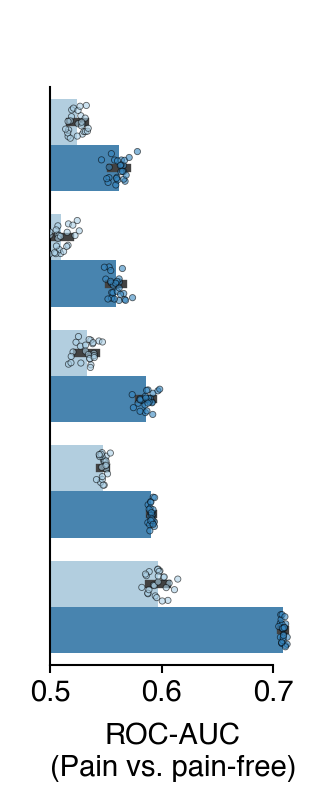

In [7]:
fig, ax = plt.subplots(figsize=(1.15,2.7))

colors = ['#3787c0','#abd0e6']

order = ['Psychosocial', 'Blood', 'Bone', 'Stacked', 'PRS']
colors = ['#abd0e6','#3787c0']
order = ['Psychosocial', 'Blood', 'Bone', 'PRS', 'Stacked'][::-1]
horder = ['Acute (< 3 mos.)','Chronic (> 3 mos.)']

order = ['Psychosocial', 'Blood', 'Bone', 'Stacked', 'PRS']
horder = ['Chronic (> 3 mos.)','Acute (< 3 mos.)']
colors = ['#3787c0','#abd0e6']

bar2 = sns.barplot(data=general_plot, x='AUC', hue='Pain', y=general_plot.modality,
            palette=colors, ci='sd', orient='h', errwidth=2, capsize=0,order=order, hue_order=horder,
            edgecolor=None,linestyle='-',ax=ax)
# Overlay the scatterplot
sns.stripplot(data=general_plot, x='AUC', y=general_plot.modality, hue='Pain', palette=['#3787c0','#abd0e6'], jitter=0.3, alpha=0.6, order=order, dodge=True, ax=ax, size=1.5, linewidth=.2, edgecolor="black",
             hue_order=horder,legend=False)

ax.set_ylabel('',fontsize=0)
ax.set_xlabel('ROC-AUC\n(Pain vs. pain-free)',
                 fontsize=7
                )

ax.set_xlim(0.5,0.72)
ax.spines["bottom"].set_bounds((.5, .7))
ax.set_ylim(-.5,len(general_plot.modality.unique()))

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines["left"].set_bounds((-0.5,4.5))

ax.tick_params(axis='both', which='both', 
                 )
    
ax.legend(frameon=False,loc='right',fontsize=6)

ax.set_yticklabels([])
ax.set_yticks([])

ax.set_xticks(np.arange(.5,.75,.05))
ax.set_xticks(np.arange(.5,.75,.1))

ax.tick_params(which='both', direction='out',labelsize=7)

fig.tight_layout()


plt.legend('',frameon=False)

plt.show()

# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_1_CP_models/CPvsAP_Plot_T0.pdf", 
#             dpi=300, transparent=True, bbox_inches='tight')

## Hertiability estimated from GWAS for acute and chronic pain

In [8]:
h2 = pd.read_csv('/Users/Patty/Desktop/PRS_files/h2_all_wFDR.txt',sep='\t')

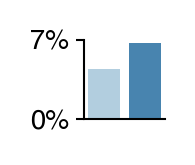

In [9]:
h2_pain = h2[(h2['pheno'] == 'ChronicPain') | (h2['pheno'] == 'AcutePain')]
h2_pain.h2 = h2_pain.h2 * 100
fig,ax = plt.subplots(figsize=(.35,.35))
sns.barplot(data=h2_pain,x='pheno',y='h2',hue='pheno',palette=['#3787c0','#abd0e6'],order=['AcutePain','ChronicPain'],ax=ax)

# Removing the labels, ticks, and text from the plot except for the y tick labels.
ax.set_xlabel('')  # Remove x-axis label
ax.set_xticks([])  # Remove x-axis ticks
ax.set_ylabel('')  # Remove y-axis label
ax.set_ylim(0,7)
ax.set_yticks([0,7])
ax.set_yticklabels(['0%','7%'])
sns.despine()

# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_1_CP_Classification/CPvsAP_h2.pdf", 
#             dpi=300, transparent=True, bbox_inches='tight')

## Hertiability estimated from GWAS for chronic pain body sites

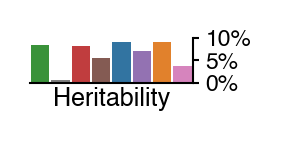

In [11]:
pain_order = ['ChronicHeadaches', 'ChronicFacialPain', 'ChronicNeckShoulderPain', 'ChronicStomachAbdominalPain', 
              'ChronicBackPain', 'ChronicHipPain', 'ChronicKneePain','ChronicWidespreadPain']
h2_paintypes = h2[h2.pheno.isin(pain_order)]
h2_paintypes.h2 = h2_paintypes.h2 * 100

fig,ax = plt.subplots(figsize=(.7,.2))
sns.barplot(data=h2_paintypes,x='pheno',y='h2',hue='pheno',width=.9, order=pain_order,
            ax=ax)

# Removing the labels, ticks, and text from the plot except for the y tick labels.
ax.set_xlabel('Heritability',labelpad=1,fontsize=6)  # Remove x-axis label
ax.set_xticks([])  # Remove x-axis ticks
ax.set_ylabel('')  # Remove y-axis label
ax.set_ylim(0,10)
ax.set_yticks([0,5,10])
ax.set_yticklabels(['0%','5%','10%'],fontsize=5.5)
sns.despine(left=True,right=False)

# Moving y-axis to the right
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.tick_params(axis='y', length=1.5)

# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_1_CP_models/Paintype_h2.pdf", 
#             dpi=300, transparent=True, bbox_inches='tight')

## Loading UKB variables

In [12]:
brain_eid = pd.read_csv(home_dir + 'UKB_Named_MRI_37k.csv').eid

cols = ['eid', 
        # T0
        'ChronicPain_T0',
        'ChronicWidespreadPain_T0', 
        'ChronicHeadaches_T0',
        'ChronicNeckShoulderPain_T0', 
        'ChronicHipPain_T0', 
        'ChronicBackPain_T0', 
        'ChronicStomachAbdominalPain_T0', 
        'ChronicKneePain_T0',
        'ChronicFacialPain_T0', 
        'NumberChronicPainTypes_T0',
        # T2
        'ChronicPain_T2',
        'ChronicWidespreadPain_T2', 
        'ChronicHeadaches_T2',
        'ChronicNeckShoulderPain_T2', 
        'ChronicHipPain_T2', 
        'ChronicBackPain_T2', 
        'ChronicStomachAbdominalPain_T2', 
        'ChronicKneePain_T2',
        'ChronicFacialPain_T2', 
        'NumberChronicPainTypes_T2',
        'NumberReportedNonCancer_T0',
        'NumberReportedNonCancer_T2',
       # Impact
        'OverallHealthRating_T0',
        'UnableWorkDueSicknessDisability_T0',
        'OverallHealthRating_T2',
        'UnableWorkDueSicknessDisability_T2',
       # Additional
        'Age_T0',
        'Age_T2',
        'Sex_T0',
       'UKBiobankSite_T2']
UKB = pd.read_csv(home_dir + 'UKB_NoBrain_500K_V4.csv',low_memory=False,usecols=cols) #UKB demographic data
UKB = UKB.drop(columns=UKB.filter(like='T0').columns[113:172])


# Plot model performance for Number of Pain Sites (Spreading), ranging from 1 to 4+ chronic pain sites. Also plot sample size for each phenotype at each modality

In [13]:
cp_T0 = {key: value for key, value in pain_T0.items() if 'site' in key}
cp_T2 = {key: value for key, value in pain_T2.items() if 'site' in key}
cp_T2 = {k: v for k, v in cp_T2.items() if 'Psychosocial' not in k}
cp = cp_T0.copy()
cp.update(cp_T2)

In [14]:
pain_auc = pd.concat(cp[i]['results_df'][['AUC_test']] for i in cp.keys() if 'site' in i)
pain_auc.index = [i[:-4] for i in pain_auc.index]
pain_auc = pain_auc.T.melt()[::-1].reset_index(drop=True)
pain_auc['n'] = [cp[i]['roc_curve'][1].sum() * 5 for i in cp.keys() if 'site' in i][::-1]
pain_auc.columns = ['modality','AUC', 'n']

In [15]:
def cohens_d(series1, series2):
    """
    Compute Cohen's d.

    Args:
        series1 (pd.Series): Pandas Series 1
        series2 (pd.Series): Pandas Series 2

    Returns:
        float: Cohen's d
    """
    # calculate the mean of each series
    mean1, mean2 = series1.mean(), series2.mean()

    # calculate the variance of each series
    var1, var2 = series1.var(), series2.var()

    # number of observations in each series
    n1, n2 = len(series1), len(series2)

    # calculate the pooled standard deviation
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    
    # calculate Cohen's d
    d = (mean1 - mean2) / pooled_std
    
    return d

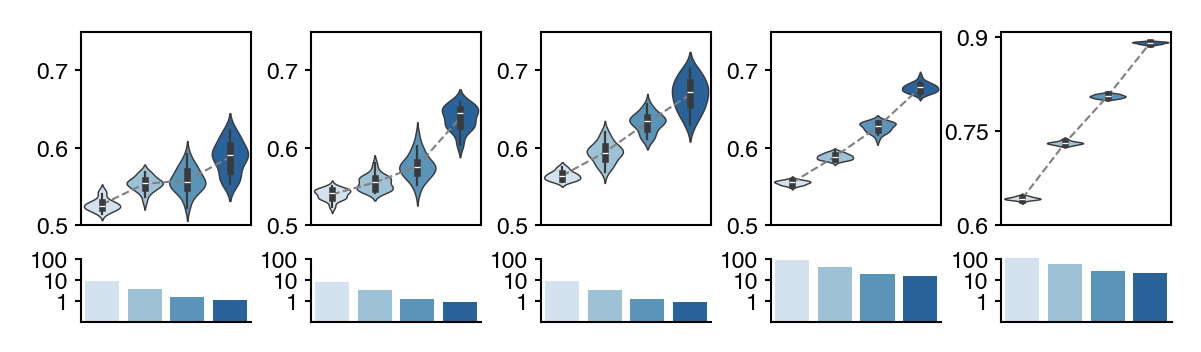

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you've loaded your dataframe as pain_T2_auc

# Define modalities
modalities = ['PRS', 'Stacked', 'Bone', 'Blood', 'Psychosocial']

# Define the yticks for each subplot

yticks_list = [
    [0.55, 0.65, 0.75],
    [0.55, 0.65, 0.75],
    [0.55, 0.65, 0.75],
    [0.55, 0.65, 0.75],
    [0.60, 0.75, 0.90]
]

yticks_list = [
    [0.5, 0.6, 0.7],
    [0.5, 0.6, 0.7],
    [0.5, 0.6, 0.7],
    [0.5, 0.6, 0.7],
    [0.60, 0.75, 0.90]
]


# Set up the figure with subplots side by side
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(4, 1.35))

# Plot each modality
for i, modality in enumerate(modalities):
    # Subset data for the current modality
    subset_data = pain_auc[pain_auc['modality'].str.contains(modality)][::-1]
    
    mean_values = subset_data.groupby('modality').mean().sort_values('AUC')
    axs[i].plot(mean_values['AUC'], color='grey', linestyle='--', linewidth=0.5)
    
    # Create violin plot
    sns.violinplot(data=subset_data, x='modality', y='AUC', palette='Blues', hue='modality', inner='box', width=.85, linewidth=.35, ax=axs[i])
    
    
    # Create an inset axis for the bar plot
    axins = axs[i].inset_axes([0, -0.5, 1, 1/3])  # [x, y, width, height]
    sns.barplot(x='modality', y='n', data=subset_data, ax=axins, errorbar=None, palette='Blues', hue='modality')
    axins.set_xticks([])
    axins.set_xlabel('')
    axins.set_ylabel('')
    axins.set_yscale('log')
    axins.set_ylim(100, 115000)  # Adjusting the scale from 1 to 100k
    axins.spines["left"].set_bounds((100, 100000))
    log_ticks = [1000, 10000, 100000]
    log_ticklabels = ['1', '10', '100']
    axins.set_yticks(log_ticks)
    axins.set_yticklabels(log_ticklabels,fontsize=5.5)
    axins.tick_params(axis='y', length=1.5)
    sns.despine(ax=axins, top=True, right=True)
    
    # Remove x-ticks and x-label
    axs[i].set_xticks([])
    axs[i].set_xlabel('')
    
    # Set yticks and yticklabels manually based on the specified values
    if i < len(yticks_list):  # to ensure we don't go out of index for yticks_list
        axs[i].set_yticks(yticks_list[i])
        axs[i].set_yticklabels(yticks_list[i],fontsize=5.5)

    # Adjust y-ticks to display only 4 labels and shorten the tick length
    ymin, ymax = axs[i].get_ylim()
    
    axs[i].tick_params(axis='y', length=1.5)
        
    # Set y-limits for the first 4 subplots
    if i < 4:  
        axs[i].set_ylim(0.5, 0.75)
        
    axs[i].set_ylabel('')
    

plt.tight_layout()
fig.subplots_adjust(wspace=0.35)
plt.show()
# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_1_CP_models/violin.pdf", dpi=300, transparent=True, bbox_inches='tight')

# Plot model performance for chronic pain body sites

In [17]:
cp_T0 = {key: value for key, value in pain_T0.items() if 'Chronic' in key}
cp_T2 = {key: value for key, value in pain_T2.items() if 'Chronic' in key}
cp_T0 = {k: v for k, v in cp_T0.items() if 'ChronicPain' not in k}
cp_T2 = {k: v for k, v in cp_T2.items() if 'ChronicPain' not in k}
cp_T2 = {k: v for k, v in cp_T2.items() if 'Psychosocial' not in k}
cp_types = cp_T0.copy()
cp_types.update(cp_T2) 

In [18]:
pain_auc = pd.concat(cp_types[i]['results_df'][['AUC_test']] for i in cp_types.keys() if 'Chronic' in i)
pain_auc.index = [i[:-4] for i in pain_auc.index]
pain_auc = pain_auc.T.melt()[::-1].reset_index(drop=True)
pain_auc['n'] = [cp_types[i]['roc_curve'][1].sum() * 5 for i in cp_types.keys() if 'Chronic' in i][::-1]
pain_auc.columns = ['modality','AUC', 'n']

In [19]:
import palettable
from matplotlib.colors import ListedColormap
cmap = ListedColormap(palettable.tableau.Tableau_10.mpl_colors)

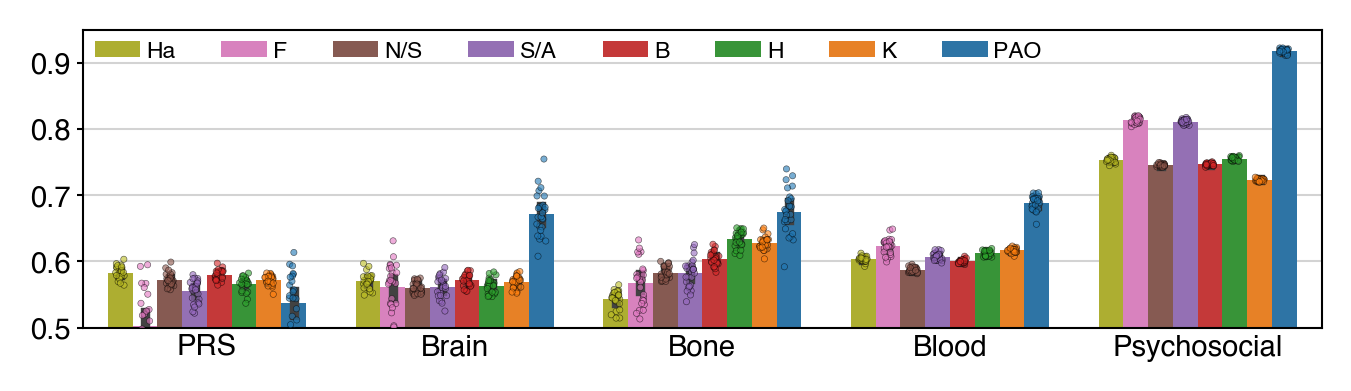

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming pain_auc is already loaded
df = pain_auc.copy()

# Extract pain type and modality
df['pain_type'] = df['modality'].apply(lambda x: x.split('_')[0])
df['modal'] = df['modality'].apply(lambda x: x.split('_')[1])

# Filter out the required modalities
modalities = ['PRS', 'Stacked', 'Bone', 'Blood', 'Psychosocial']
df = df[df['modal'].isin(modalities)]

# Sort dataframe for plotting
df.sort_values(by=['modal', 'pain_type'], inplace=True)

# Create a Manhattan-style plot
fig = plt.figure(figsize=(4.5, 1.3))

# Specify the order of plotting
order = ['PRS', 'Stacked', 'Bone', 'Blood', 'Psychosocial']

# Define a dictionary for pain type annotations
pain_annotations = {
    'ChronicHeadaches': 'Ha',
    'ChronicFacialPain': 'F',
    'ChronicNeckShoulderPain': 'N/S',
    'ChronicStomachAbdominalPain': 'S/A',
    'ChronicBackPain': 'B',
    'ChronicHipPain': 'H',
    'ChronicKneePain': 'K',
    'ChronicWidespreadPain': 'PAO'
}

# Specify the order for pain types
pain_order = ['ChronicHeadaches', 'ChronicFacialPain', 'ChronicNeckShoulderPain', 'ChronicStomachAbdominalPain', 
              'ChronicBackPain', 'ChronicHipPain', 'ChronicKneePain','ChronicWidespreadPain']
orig_palette = sns.color_palette()  # This gets the current default palette
orig_palette = palettable.tableau.Tableau_10.mpl_colors
modified_palette = orig_palette[:-3] + orig_palette[-2:-1]
reversed_palette = modified_palette[::-1]
ax = sns.barplot(x="modal", y="AUC", hue="pain_type", data=df, order=order, hue_order=pain_order, palette=reversed_palette, zorder=2, saturation=.8)
sns.stripplot(x="modal", y="AUC", hue="pain_type", data=df, order=order, hue_order=pain_order, palette=reversed_palette, dodge=True, jitter=.15, size=1.5, alpha=0.6, zorder=3, marker="o", legend=False, edgecolor='k',linewidth=.15
              # color='k', palette=['white','white','white','white','white','white','white'], edgecolor='k', linewidth=.2
             )

# Adjust legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [pain_annotations[label] for label in labels]

# Set the legend to be horizontal, remove its title, and place it at the top left
ax.legend(handles=handles, labels=new_labels, loc="upper left", frameon=False, borderpad=0, ncol=len(new_labels), handletextpad=0.25, fontsize=5.5)

# Set custom xticklabels
custom_xticklabels = ['PRS', 'Brain', 'Bone', 'Blood', 'Psychosocial']
ax.set_xticklabels(custom_xticklabels,fontsize=7)

plt.ylim(0.5,0.95)
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9],fontsize=7)  # Set y-ticks
plt.title("")
plt.ylabel("")
plt.xlabel("")

# Remove x-ticks
ax.tick_params(axis='x', which='both', length=0)
ax.tick_params(axis='y', length=1.5)

# Add a light grey grid on the y-axis
ax.yaxis.grid(True, color='lightgray',linewidth=0.5)

plt.tight_layout()
plt.show()
# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_1_CP_Classification/paintypes_bar.pdf", dpi=300, transparent=True, bbox_inches='tight')


/var/folders/fb/fwsj02n54bd7zmtt541bh0140000gn/T/ipykernel_54469/964612146.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(custom_xticklabels,fontsize=7)


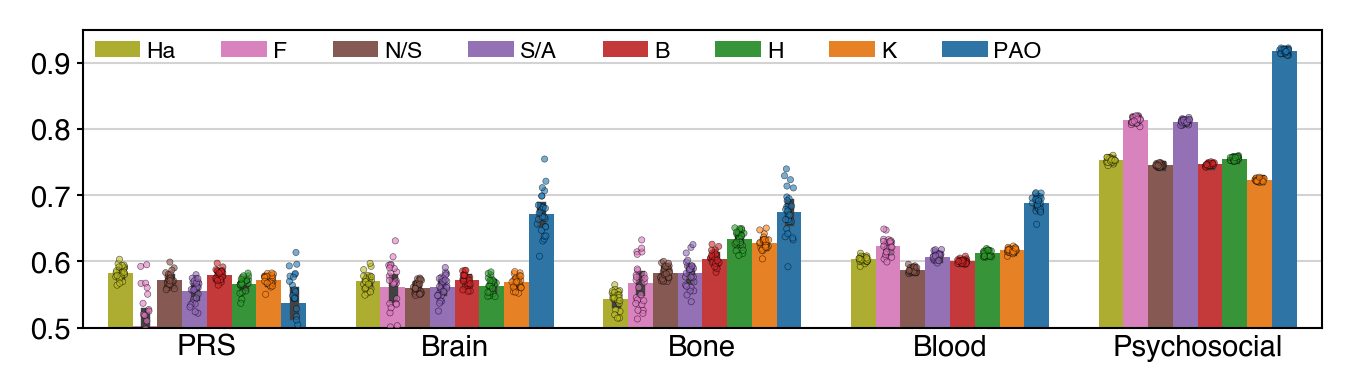

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming pain_auc is already loaded
df = pain_auc.copy()

# Extract pain type and modality
df['pain_type'] = df['modality'].apply(lambda x: x.split('_')[0])
df['modal'] = df['modality'].apply(lambda x: x.split('_')[1])

# Filter out the required modalities
modalities = ['PRS', 'Stacked', 'Bone', 'Blood', 'Psychosocial']
df = df[df['modal'].isin(modalities)]

# Sort dataframe for plotting
df.sort_values(by=['modal', 'pain_type'], inplace=True)

# Create a Manhattan-style plot
fig = plt.figure(figsize=(4.5, 1.3))

# Specify the order of plotting
order = ['PRS', 'Stacked', 'Bone', 'Blood', 'Psychosocial']

# Define a dictionary for pain type annotations
pain_annotations = {
    'ChronicHeadaches': 'Ha',
    'ChronicFacialPain': 'F',
    'ChronicNeckShoulderPain': 'N/S',
    'ChronicStomachAbdominalPain': 'S/A',
    'ChronicBackPain': 'B',
    'ChronicHipPain': 'H',
    'ChronicKneePain': 'K',
    'ChronicWidespreadPain': 'PAO'
}

# Specify the order for pain types
pain_order = ['ChronicHeadaches', 'ChronicFacialPain', 'ChronicNeckShoulderPain', 'ChronicStomachAbdominalPain', 
              'ChronicBackPain', 'ChronicHipPain', 'ChronicKneePain','ChronicWidespreadPain']
orig_palette = sns.color_palette()  # This gets the current default palette
orig_palette = palettable.tableau.Tableau_10.mpl_colors
modified_palette = orig_palette[:-3] + orig_palette[-2:-1]
reversed_palette = modified_palette[::-1]
ax = sns.barplot(x="modal", y="AUC", hue="pain_type", data=df, order=order, hue_order=pain_order, palette=reversed_palette, zorder=2, saturation=.8)
sns.stripplot(x="modal", y="AUC", hue="pain_type", data=df, order=order, hue_order=pain_order, palette=reversed_palette, dodge=True, jitter=.15, size=1.5, alpha=0.6, zorder=3, marker="o", legend=False, edgecolor='k',linewidth=.15
              # color='k', palette=['white','white','white','white','white','white','white'], edgecolor='k', linewidth=.2
             )

# Adjust legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [pain_annotations[label] for label in labels]

# Set the legend to be horizontal, remove its title, and place it at the top left
ax.legend(handles=handles, labels=new_labels, loc="upper left", frameon=False, borderpad=0, ncol=len(new_labels), handletextpad=0.25, fontsize=5.5)

# Set custom xticklabels
custom_xticklabels = ['PRS', 'Brain', 'Bone', 'Blood', 'Psychosocial']
ax.set_xticklabels(custom_xticklabels,fontsize=7)

plt.ylim(0.5,0.95)
plt.yticks([0.5, 0.6, 0.7, 0.8, 0.9],fontsize=7)  # Set y-ticks
plt.title("")
plt.ylabel("")
plt.xlabel("")

# Remove x-ticks
ax.tick_params(axis='x', which='both', length=0)
ax.tick_params(axis='y', length=1.5)

# Add a light grey grid on the y-axis
ax.yaxis.grid(True, color='lightgray',linewidth=0.5)

plt.tight_layout()
plt.show()
# fig.savefig("/Users/Patty/Desktop/Biomarker_Paper/Fig_1_CP_Classification/paintypes_bar.pdf", dpi=300, transparent=True, bbox_inches='tight')
